# Problem Statement
The goal is to build a machine learning model that predicts the probability of customer deflection (churn) using anonymized customer data. Predictions are evaluated with logloss, emphasizing well-calibrated probabilities to help businesses take proactive retention measures.

# Import Libraries

In [1]:
# Importing required tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Models 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# tuning and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, log_loss

# saving model
import pickle
import joblib

# Load Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Exploratory Data Analysis

In [3]:
# checking shape
train_df.shape, test_df.shape

((404165, 12), (101041, 11))

In [4]:
train_df.head()

,Id,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,186878,23.0,Male,44.0,18.0,0.0,19.0,Basic,Quarterly,846.18,18.0,0.0
1,414188,19.0,Male,41.0,29.0,1.0,26.0,Basic,Annual,149.04,10.0,1.0
2,419671,40.0,Male,48.0,11.0,3.0,19.0,Basic,Annual,266.00,9.0,1.0
3,428771,44.0,Female,58.0,21.0,2.0,27.0,Standard,Quarterly,662.00,16.0,1.0
4,302010,49.0,Male,24.0,29.0,9.0,9.0,Standard,Monthly,857.00,8.0,1.0


In [5]:
test_df.head()

,Id,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
0,105946,47.0,Male,5.0,22.0,4.0,16.0,Basic,Quarterly,252.00,27.0
1,101553,20.0,Male,25.0,18.0,4.0,18.0,Standard,Annual,742.00,8.0
2,468232,21.0,Male,49.0,14.0,6.0,12.0,Premium,Annual,668.00,19.0
3,249,33.0,Female,17.0,26.0,4.0,24.0,Premium,Annual,459.00,12.0
4,452750,46.0,Male,7.0,18.0,3.0,2.0,Standard,Annual,788.94,12.0


In [6]:
# copying IDs from test data for the submission purpose
test_ids = test_df['Id'].copy()

# dropping 'ID' column form train and test data
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

# renaming 'Churn' to 'target' 
train_df.rename(columns={'Churn':'target'}, inplace=True)
train_df[:5]

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,target
0,23.0,Male,44.0,18.0,0.0,19.0,Basic,Quarterly,846.18,18.0,0.0
1,19.0,Male,41.0,29.0,1.0,26.0,Basic,Annual,149.04,10.0,1.0
2,40.0,Male,48.0,11.0,3.0,19.0,Basic,Annual,266.00,9.0,1.0
3,44.0,Female,58.0,21.0,2.0,27.0,Standard,Quarterly,662.00,16.0,1.0
4,49.0,Male,24.0,29.0,9.0,9.0,Standard,Monthly,857.00,8.0,1.0


## train data analysis

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404165 entries, 0 to 404164
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                404165 non-null  float64
 1   Gender             404165 non-null  object 
 2   Tenure             404165 non-null  float64
 3   Usage Frequency    404165 non-null  float64
 4   Support Calls      404165 non-null  float64
 5   Payment Delay      404165 non-null  float64
 6   Subscription Type  404165 non-null  object 
 7   Contract Length    404165 non-null  object 
 8   Total Spend        404165 non-null  float64
 9   Last Interaction   404165 non-null  float64
 10  target             404165 non-null  float64
dtypes: float64(8), object(3)
memory usage: 33.9+ MB


In [8]:
train_df.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,target
count,404165.000000,404165.000000,404165.000000,404165.000000,404165.000000,404165.000000,404165.000000,404165.000000
mean,39.709388,31.346693,15.718976,3.830703,13.494808,620.278390,14.603890,0.554776
std,12.681057,17.231919,8.617287,3.134619,8.453428,245.179751,8.609196,0.496991
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,29.000000,16.000000,8.000000,1.000000,6.000000,446.670000,7.000000,0.000000
50%,40.000000,32.000000,16.000000,3.000000,13.000000,649.000000,14.000000,1.000000
75%,49.000000,46.000000,23.000000,6.000000,20.000000,824.000000,22.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [9]:
# checking null value
train_df.isna().sum()

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
target               0
dtype: int64

In [10]:
train_df.isnull().sum()

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
target               0
dtype: int64

In [11]:
train_df.duplicated().sum()

np.int64(0)

In [12]:
target_counts = train_df['target'].value_counts()
target_counts

target
1.0    224221
0.0    179944
Name: count, dtype: int64

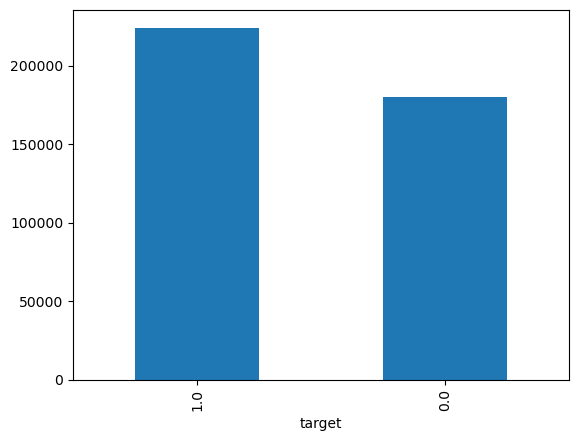

In [13]:
target_counts.plot(kind='bar')
plt.show()

### Univariate Analysis (analysis of single variable/feature)

In [14]:
# creating re-usable functions for Univariate analysis
def check_skewness(df):
    """
    gives skewness of numerical data
    """
    return df.skew(numeric_only=True)

def categorical_analysis(df):
    """
    takes dataframe and shows its value_counts, missing_value and also plots barplot of each col
    """
    cat_col = df.select_dtypes(include=['object']).columns
    for col in cat_col:
        print(f"\nfeature:  {col}")
        print(df[col].value_counts(normalize=True))
        print(f"missing: {df[col].isnull().sum()}")
        print(df[col].value_counts().plot(kind='bar'))
        plt.show()

In [15]:
check_skewness(train_df)

Age                 0.143368
Tenure             -0.069591
Usage Frequency    -0.035075
Support Calls       0.544875
Payment Delay       0.199874
Total Spend        -0.396349
Last Interaction    0.155220
target             -0.220431
dtype: float64


feature:  Gender
Gender
Male      0.555043
Female    0.444957
Name: proportion, dtype: float64
missing: 0
Axes(0.125,0.11;0.775x0.77)


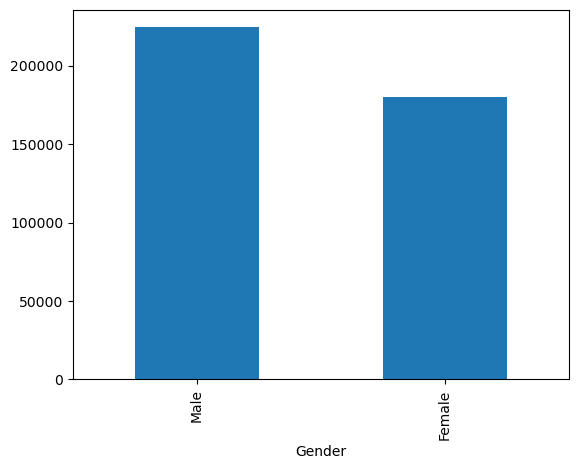


feature:  Subscription Type
Subscription Type
Standard    0.337360
Premium     0.336479
Basic       0.326161
Name: proportion, dtype: float64
missing: 0
Axes(0.125,0.11;0.775x0.77)


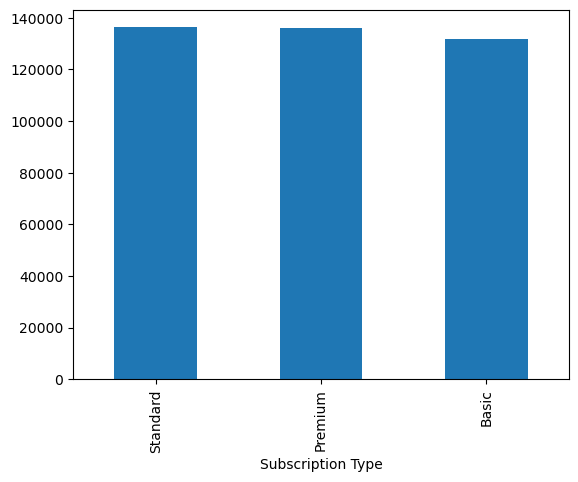


feature:  Contract Length
Contract Length
Annual       0.393273
Quarterly    0.390823
Monthly      0.215904
Name: proportion, dtype: float64
missing: 0
Axes(0.125,0.11;0.775x0.77)


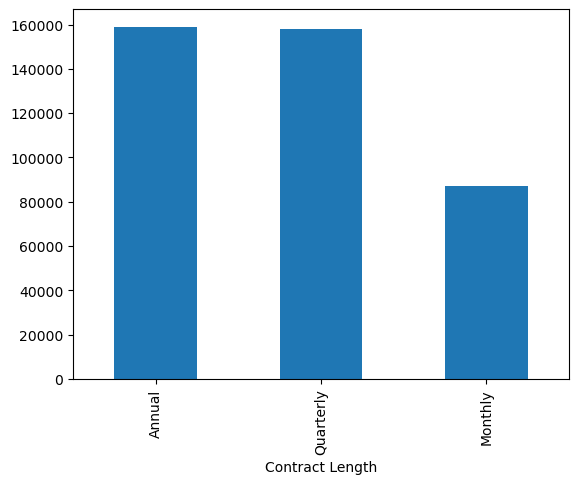

In [16]:
# Analysing the categorical columns in the data
categorical_analysis(train_df)

### Bivariate analysis (comparing one column/feature with the other one)

**checking impact of each feature on target value**

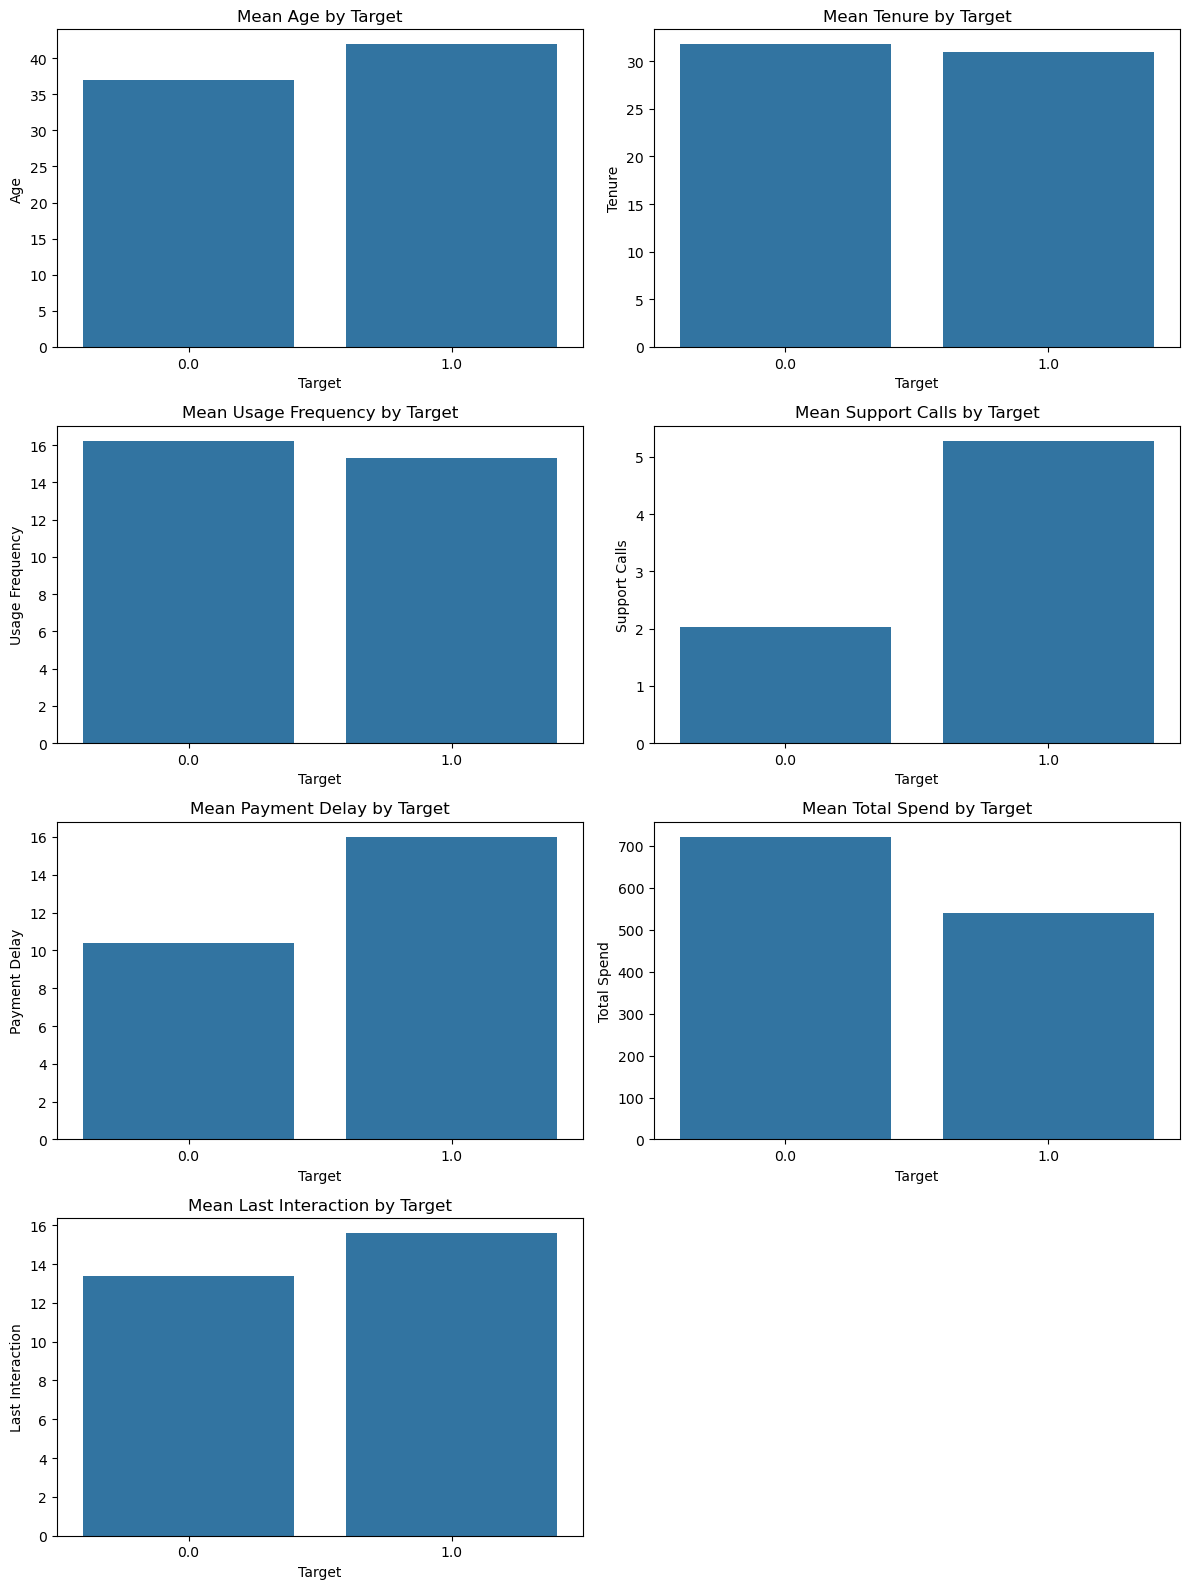

In [17]:
# Numerical_column vs target
def num_vs_target(df):
    """
    takes dataframe and plots barplot with mean of each numerical col and target
    """
    num_col = df.select_dtypes(include=['int64', 'float64']).columns.drop('target', errors='ignore')
    n_cols = 2
    n_rows = (len(num_col) + 1) // n_cols

    # Creating subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
    axes = axes.flatten()

    # for loop through each plot
    for i, col in enumerate(num_col):
        sns.barplot(x='target', y=col, data=df, estimator='mean', ax=axes[i], errorbar=None)
        axes[i].set_title(f'Mean {col} by Target')
        axes[i].set_xlabel('Target')
        axes[i].set_ylabel(col)

    # Hiding any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


# Using functions
num_vs_target(train_df)

According to EDA, `Support_calls`, `Payment_delay`, and `Total_spend` has some influence on target value

#### Applying crosstab on categorical feature vs target

In [18]:
def cat_vs_tar(df):
    """
    takes dataframe as input and makes crosstab with each categorical column and target value to show the proportion between them
    """
    cat_col = df.select_dtypes(include=['object']).columns
    for col in cat_col:
        print(f'Categorical_feature: {col}')
        print('\n')
        cr_tab = pd.crosstab(df[col], df['target'], normalize='index')
        print(cr_tab)
        print('\n' + '-'*50 + '\n')

In [19]:
cat_vs_tar(train_df)

Categorical_feature: Gender


target       0.0       1.0
Gender                    
Female  0.351465  0.648535
Male    0.520387  0.479613

--------------------------------------------------

Categorical_feature: Subscription Type


target                  0.0       1.0
Subscription Type                    
Basic              0.431207  0.568793
Premium            0.452656  0.547344
Standard           0.451364  0.548636

--------------------------------------------------

Categorical_feature: Contract Length


target                0.0       1.0
Contract Length                    
Annual           0.538683  0.461317
Monthly          0.099185  0.900815
Quarterly        0.542344  0.457656

--------------------------------------------------



In [20]:
# Correlation matrix
train_df_corr = train_df.corr(numeric_only=True)
train_df_corr

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,target
Age,1.000000,-0.010521,-0.013961,0.147275,0.059997,-0.078772,0.027969,0.191968
Tenure,-0.010521,1.000000,-0.020026,-0.013351,-0.004560,0.015854,-0.005630,-0.021624
Usage Frequency,-0.013961,-0.020026,1.000000,-0.025644,-0.012951,0.019539,-0.006023,-0.053905
Support Calls,0.147275,-0.013351,-0.025644,1.000000,0.175884,-0.206405,0.074856,0.516792
Payment Delay,0.059997,-0.004560,-0.012951,0.175884,1.000000,-0.125687,0.042137,0.330412
Total Spend,-0.078772,0.015854,0.019539,-0.206405,-0.125687,1.000000,-0.055164,-0.369074
Last Interaction,0.027969,-0.005630,-0.006023,0.074856,0.042137,-0.055164,1.000000,0.127598
target,0.191968,-0.021624,-0.053905,0.516792,0.330412,-0.369074,0.127598,1.000000


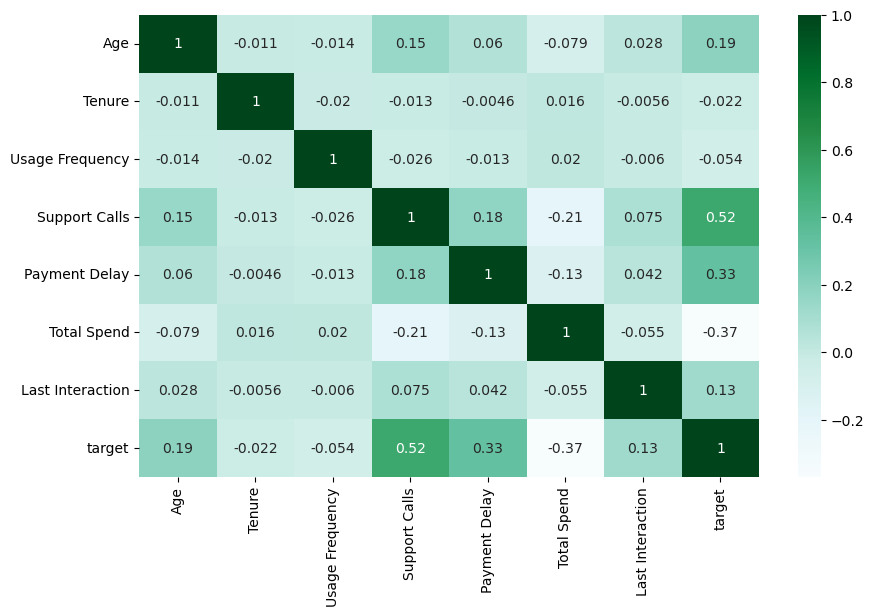

In [21]:
# Visualizing train_df_corr
plt.figure(figsize=(10, 6))
sns.heatmap(train_df_corr, cmap='BuGn', annot=True)
plt.show()

**Analysis**
1. More `support calls`, more frustated the customer, thus high chances of churn
2. More `payment delay`, high chance of churning
3. More time gap in `last interaction`, higher the chance of churning
4. Less `total spend` on products, high chance of churning

In [22]:
# Categorical column vs target
from scipy.stats import chi2_contingency
def cat_vs_target(df):
    """
    gives chi-sqaure value that shows the relationship of categorical column to the target
    """
    cat_col = df.select_dtypes(['object']).columns
    for col in cat_col:
        contingency_table = pd.crosstab(df[col], df['target'])
        chi2, p, _, _ = chi2_contingency(contingency_table)
        print(f"{col}_p-value = {p}")

cat_vs_target(train_df)

Gender_p-value = 0.0
Subscription Type_p-value = 1.2835096494611652e-34
Contract Length_p-value = 0.0


#### Detecting outliers

In [23]:
def detect_outliers_iqr(df, threshold=1.5):
    outlier_info = {}

    # Loop through all numerical columns
    for col in df.select_dtypes(include='number').columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_info[col] = {
            "num_outliers": outliers.shape[0],
          #  "outlier_indices": outliers.index.tolist()
        }

    return outlier_info

# Using function
detect_outliers_iqr(train_df)

{'Age': {'num_outliers': 0},
 'Tenure': {'num_outliers': 0},
 'Usage Frequency': {'num_outliers': 0},
 'Support Calls': {'num_outliers': 0},
 'Payment Delay': {'num_outliers': 0},
 'Total Spend': {'num_outliers': 0},
 'Last Interaction': {'num_outliers': 0},
 'target': {'num_outliers': 0}}

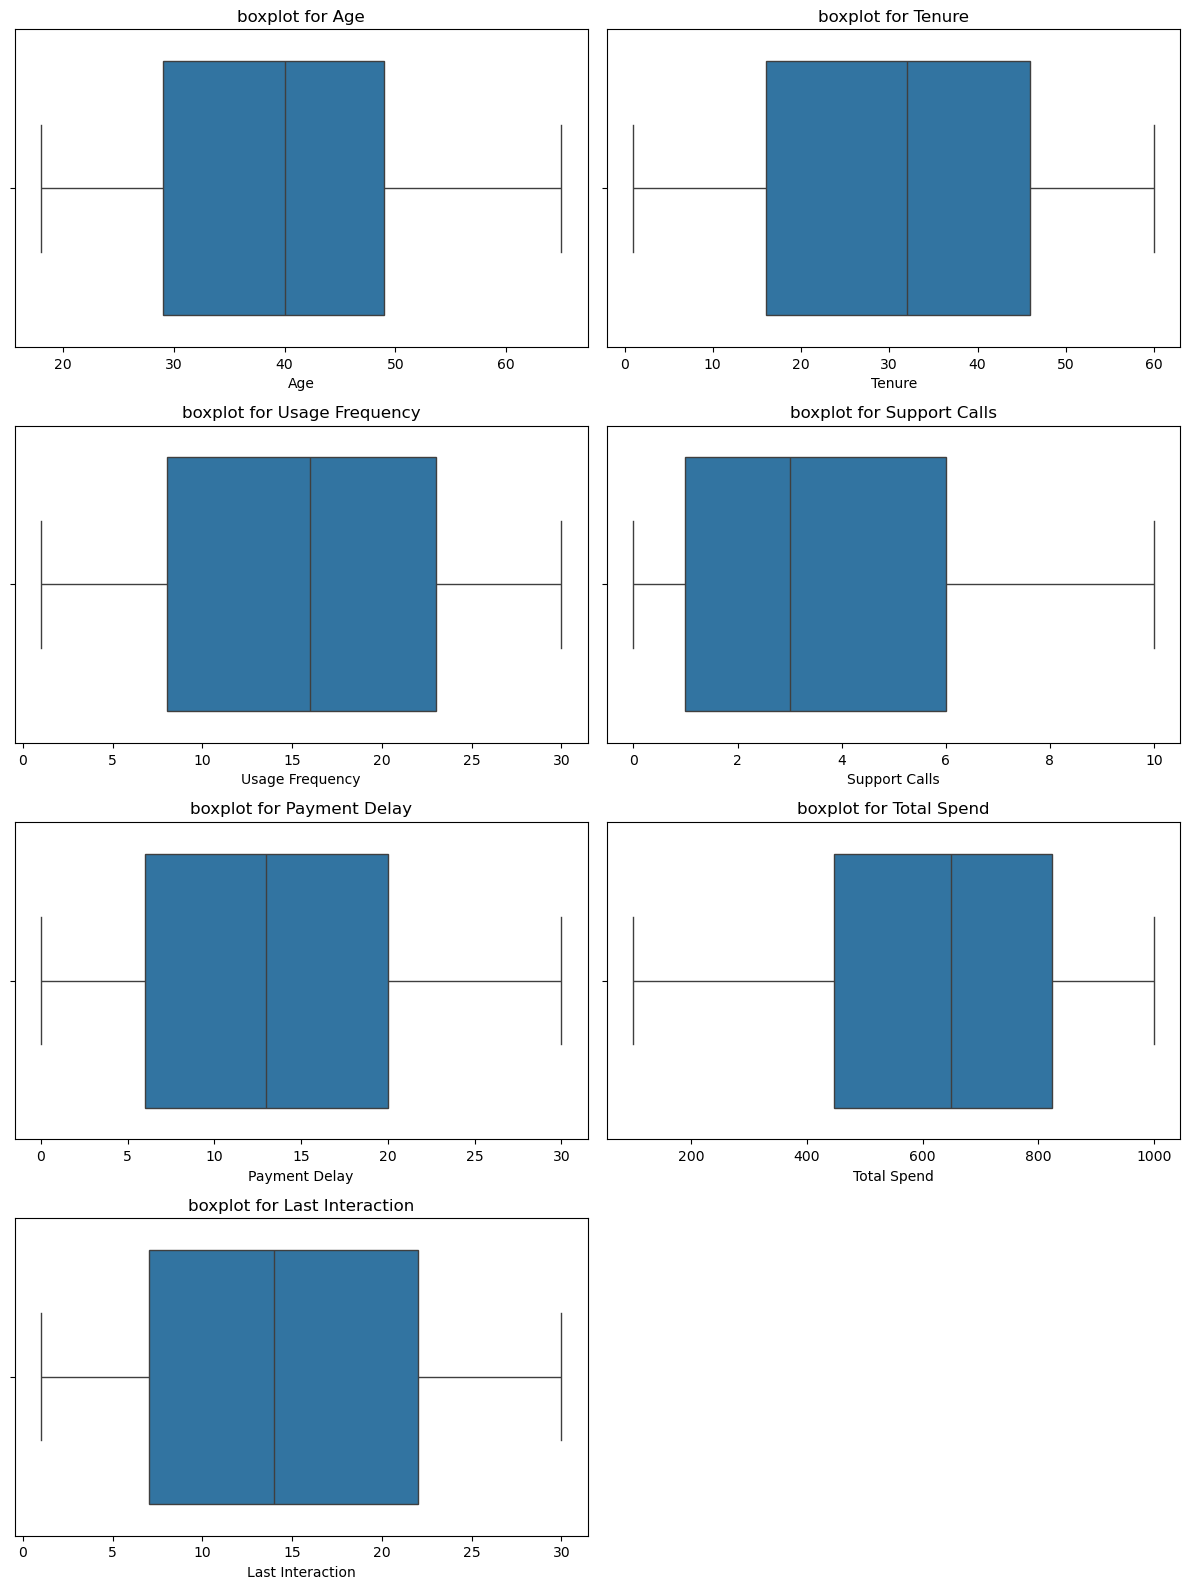

In [24]:
# Visualizing boxplot to see the number of outliers
num_col = train_df.select_dtypes(include=['int64', 'float64']).columns.drop('target', errors='ignore')
n_cols = 2
n_rows = (len(num_col) + 1) // n_cols

# Creating subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(num_col):
    sns.boxplot(x=train_df[col], ax=axes[i])
    axes[i].set_title(f'boxplot for {col}')
    
# Hide unused subplots if number of columns is odd
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()   

In [25]:
# Visualizing  numerical columns using hist plot
def plot_hist(df):
    num_col = df.select_dtypes(include=['int64', 'float64']).columns.drop('target', errors='ignore')
    n_cols = 2
    n_rows = (len(num_col) + 1) // n_cols
    
    # Creating subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
    axes = axes.flatten()

    # looping through num_col
    for i, col in enumerate(num_col):
        df[col].plot(kind='hist', ax = axes[i], bins=30, color='skyblue', edgecolor = 'black')
        axes[i].set_xlabel(col)
        
    # Hide unused subplots if number of columns is odd
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

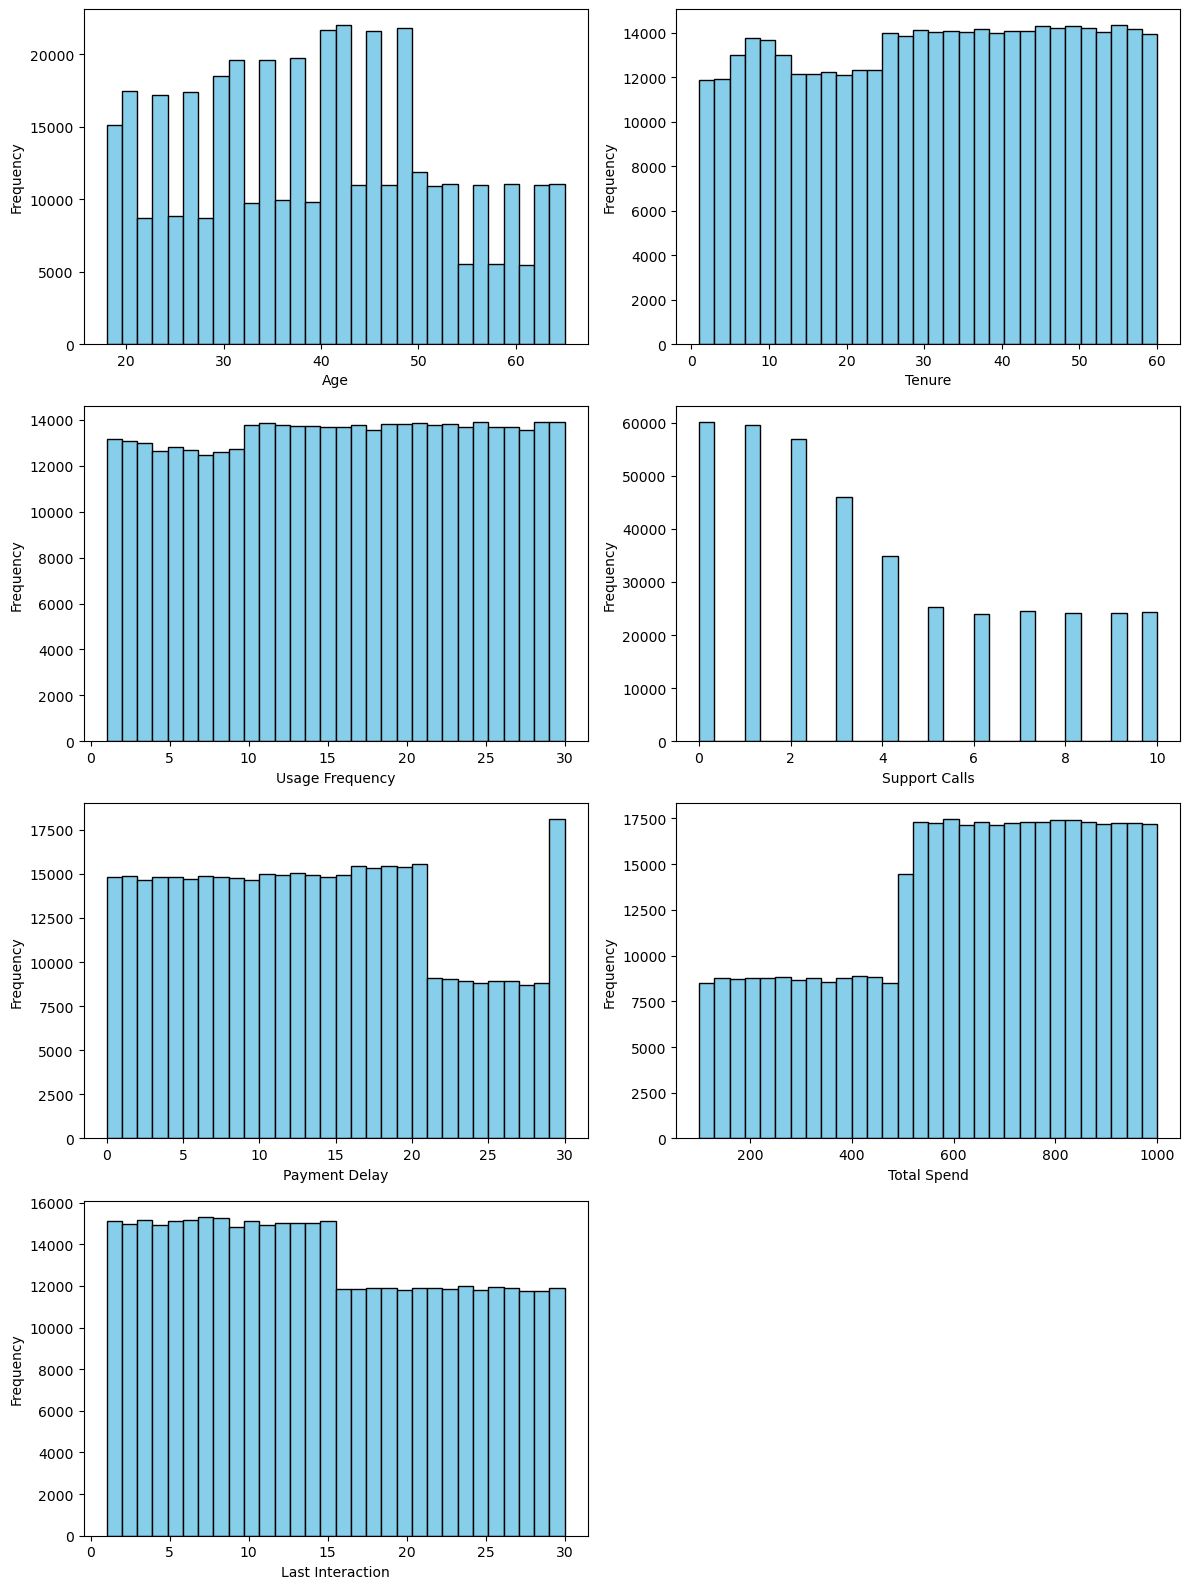

In [26]:
plot_hist(train_df)

## test data analysis

In [27]:
test_df.shape

(101041, 10)

In [28]:
test_df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
0,47.0,Male,5.0,22.0,4.0,16.0,Basic,Quarterly,252.00,27.0
1,20.0,Male,25.0,18.0,4.0,18.0,Standard,Annual,742.00,8.0
2,21.0,Male,49.0,14.0,6.0,12.0,Premium,Annual,668.00,19.0
3,33.0,Female,17.0,26.0,4.0,24.0,Premium,Annual,459.00,12.0
4,46.0,Male,7.0,18.0,3.0,2.0,Standard,Annual,788.94,12.0


In [29]:
test_df.tail()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
101036,63.0,Male,6.0,16.0,0.0,26.0,Basic,Quarterly,210.00,7.0
101037,50.0,Female,22.0,15.0,8.0,15.0,Standard,Quarterly,369.00,2.0
101038,42.0,Male,49.0,5.0,1.0,18.0,Premium,Quarterly,738.23,24.0
101039,21.0,Male,30.0,14.0,5.0,25.0,Basic,Monthly,278.00,17.0
101040,31.0,Male,43.0,28.0,3.0,4.0,Standard,Quarterly,908.62,3.0


In [30]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101041 entries, 0 to 101040
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                101041 non-null  float64
 1   Gender             101041 non-null  object 
 2   Tenure             101041 non-null  float64
 3   Usage Frequency    101041 non-null  float64
 4   Support Calls      101041 non-null  float64
 5   Payment Delay      101041 non-null  float64
 6   Subscription Type  101041 non-null  object 
 7   Contract Length    101041 non-null  object 
 8   Total Spend        101041 non-null  float64
 9   Last Interaction   101041 non-null  float64
dtypes: float64(7), object(3)
memory usage: 7.7+ MB


In [31]:
test_df.isna().sum()

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
dtype: int64

In [32]:
test_df.isnull().sum()

Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
dtype: int64

In [33]:
test_df.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction
count,101041.000000,101041.000000,101041.000000,101041.000000,101041.000000,101041.000000,101041.000000
mean,39.683307,31.365406,15.698222,3.843776,13.504983,619.250268,14.637345
std,12.628610,17.259791,8.627485,3.129526,8.442253,245.875979,8.604638
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000
25%,29.000000,16.000000,8.000000,1.000000,6.000000,444.000000,7.000000
50%,40.000000,32.000000,16.000000,3.000000,13.000000,648.000000,14.000000
75%,49.000000,46.000000,23.000000,6.000000,20.000000,823.960000,22.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000


In [34]:
test_df.duplicated().sum()

np.int64(0)

### univariate analysis

In [35]:
# checking skewness 
check_skewness(test_df)

Age                 0.148124
Tenure             -0.070029
Usage Frequency    -0.029435
Support Calls       0.540557
Payment Delay       0.199011
Total Spend        -0.388391
Last Interaction    0.153047
dtype: float64


feature:  Gender
Gender
Male      0.553676
Female    0.446324
Name: proportion, dtype: float64
missing: 0
Axes(0.125,0.11;0.775x0.77)


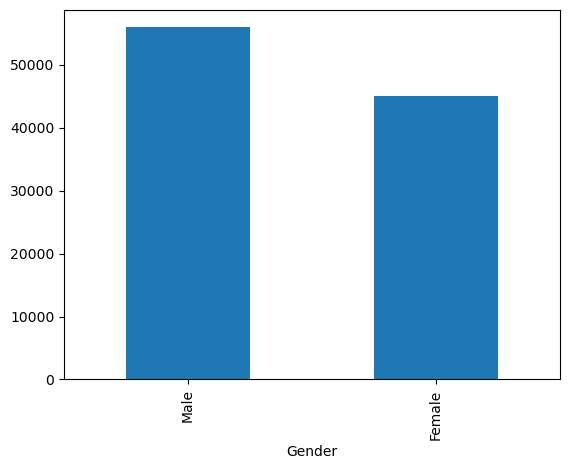


feature:  Subscription Type
Subscription Type
Standard    0.339278
Premium     0.337546
Basic       0.323176
Name: proportion, dtype: float64
missing: 0
Axes(0.125,0.11;0.775x0.77)


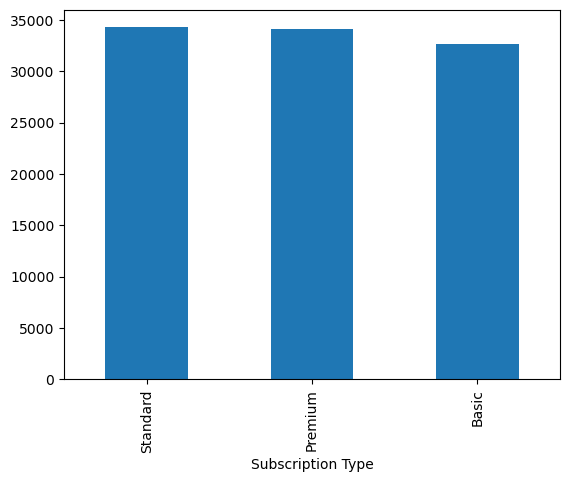


feature:  Contract Length
Contract Length
Annual       0.392524
Quarterly    0.390010
Monthly      0.217466
Name: proportion, dtype: float64
missing: 0
Axes(0.125,0.11;0.775x0.77)


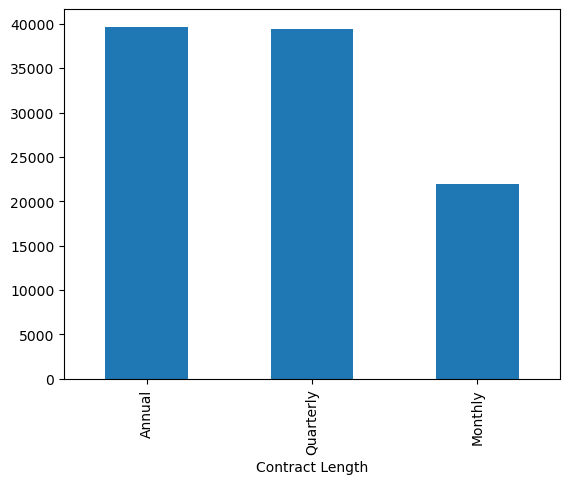

In [36]:
# categorical analysis
categorical_analysis(test_df)

**Checking outliers in test_df**

In [37]:
detect_outliers_iqr(test_df)

{'Age': {'num_outliers': 0},
 'Tenure': {'num_outliers': 0},
 'Usage Frequency': {'num_outliers': 0},
 'Support Calls': {'num_outliers': 0},
 'Payment Delay': {'num_outliers': 0},
 'Total Spend': {'num_outliers': 0},
 'Last Interaction': {'num_outliers': 0}}

# Feature Engineering

making a new feature by combining `subscription_type` and `contract_length` in train_df and test_df

In [38]:
train_df["SubType_Contract"] = train_df["Subscription Type"] + "_" + train_df["Contract Length"]
test_df["SubType_Contract"] = test_df["Subscription Type"] + "_" + test_df["Contract Length"]

In [39]:
train_df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,target,SubType_Contract
0,23.0,Male,44.0,18.0,0.0,19.0,Basic,Quarterly,846.18,18.0,0.0,Basic_Quarterly
1,19.0,Male,41.0,29.0,1.0,26.0,Basic,Annual,149.04,10.0,1.0,Basic_Annual
2,40.0,Male,48.0,11.0,3.0,19.0,Basic,Annual,266.00,9.0,1.0,Basic_Annual
3,44.0,Female,58.0,21.0,2.0,27.0,Standard,Quarterly,662.00,16.0,1.0,Standard_Quarterly
4,49.0,Male,24.0,29.0,9.0,9.0,Standard,Monthly,857.00,8.0,1.0,Standard_Monthly


In [40]:
test_df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,SubType_Contract
0,47.0,Male,5.0,22.0,4.0,16.0,Basic,Quarterly,252.00,27.0,Basic_Quarterly
1,20.0,Male,25.0,18.0,4.0,18.0,Standard,Annual,742.00,8.0,Standard_Annual
2,21.0,Male,49.0,14.0,6.0,12.0,Premium,Annual,668.00,19.0,Premium_Annual
3,33.0,Female,17.0,26.0,4.0,24.0,Premium,Annual,459.00,12.0,Premium_Annual
4,46.0,Male,7.0,18.0,3.0,2.0,Standard,Annual,788.94,12.0,Standard_Annual


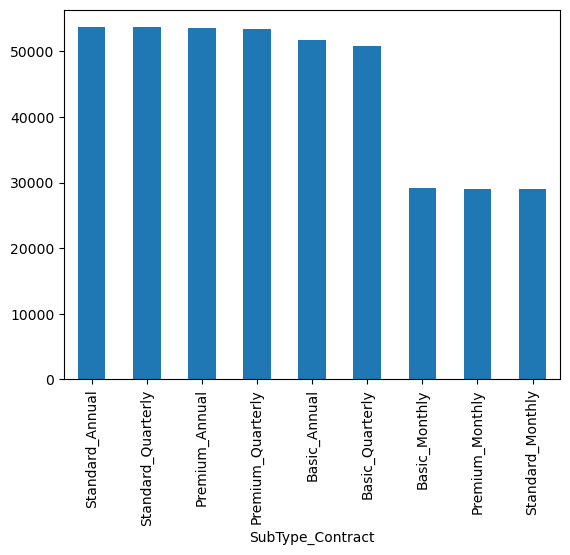

In [41]:
train_df['SubType_Contract'].value_counts().plot(kind='bar')
plt.show()

# Data Transformation

In [42]:
# Spliting train_df into X and Y
X = train_df.drop('target', axis=1)
Y = train_df['target']

# split X and Y into training and validation set data with train_test_split method
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

# renaming 'test_df' to 'x_test'
x_test = test_df

In [43]:
# checking shape
x_train.shape, y_train.shape , x_val.shape, y_val.shape, x_test.shape

((303123, 11), (303123,), (101042, 11), (101042,), (101041, 11))

In [44]:
# checking categorical column 
train_cat_col = train_df.select_dtypes(['object']).columns 
train_cat_col

Index(['Gender', 'Subscription Type', 'Contract Length', 'SubType_Contract'], dtype='object')

In [45]:
# categorical feature to numeric
# create an empty list on encoders.
encoders = {}

# looping through each column and label encoding it.
for col in train_cat_col:
    label_encoder = LabelEncoder()
    x_train[col] = label_encoder.fit_transform(x_train[col])
    x_val[col] = label_encoder.transform(x_val[col])
    x_test[col] = label_encoder.transform(x_test[col])
    encoders[col] = label_encoder
    
# saving the encoders to a pickle file
with open('encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

In [46]:
x_train['Gender'].head()

130119    0
390295    1
142487    1
254810    1
91536     1
Name: Gender, dtype: int64

In [47]:
x_val['Gender'].head()

42314     0
138761    0
228243    0
373233    1
132804    1
Name: Gender, dtype: int64

In [48]:
x_test['Gender'].head()

0    1
1    1
2    1
3    0
4    1
Name: Gender, dtype: int64

In [49]:
# loading encoders
with open('encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

In [50]:
encoders

{'Gender': LabelEncoder(),
 'Subscription Type': LabelEncoder(),
 'Contract Length': LabelEncoder(),
 'SubType_Contract': LabelEncoder()}

# Modeling

In [51]:
# making a dictionary of models
models = {'rf_classifier' : RandomForestClassifier(random_state=42),
          'xgb': XGBClassifier(random_state=42)}

# Making a function named train_model
def train_and_evaluate(models, x_train, y_train, x_val, y_val):
    models_score = {} 
    for name, model in models.items(): # iterating over models dictionary
        model.fit(x_train, y_train)  # fitting each model to the data
        test_score = model.score(x_val, y_val) # Evaluating on the test set
        models_score[name] = test_score

    return models_score

In [52]:
# setting random seed
random_state = 42

# Using our function
model_scores = train_and_evaluate(models, x_train, y_train, x_val, y_val)
model_scores

{'rf_classifier': 0.9356802121889907, 'xgb': 0.9334336216622791}

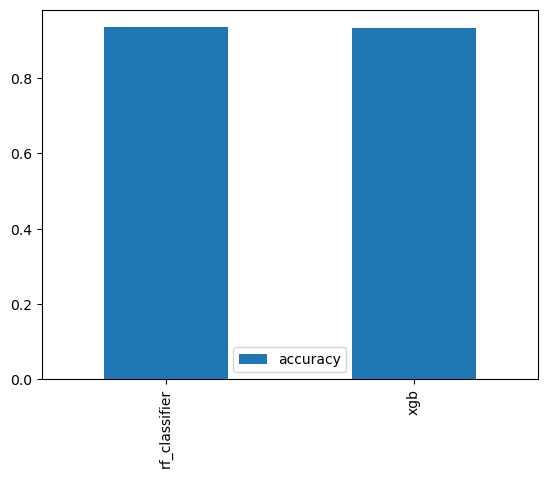

In [53]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar()
plt.show()

# Hyperparameter tuning

#### Finding best parameter for RandomForest on sample training data

In [54]:
# sampling our train_data
x_sample = x_train.sample(frac=0.1, random_state=42)
y_sample = y_train.loc[x_sample.index]
x_sample.shape, y_sample.shape

((30312, 11), (30312,))

In [55]:
# tuning parameters for RandomForest through RandomizedSearchCV
# setting parameter grid
rs_grid = {
    "n_estimators": [100, 200, 300, 400, 500],       
    "max_depth": [None, 10, 20, 30],                  
    "min_samples_split": [2, 5, 10],                 
    "min_samples_leaf": [1, 2, 4],                    
    "max_features": ["sqrt", "log2", None],          
    "bootstrap": [True, False]                     
}


# Initializing model
rf_classifier = RandomForestClassifier(random_state=42)

# Setting RandomSearchCv
rs_rf = RandomizedSearchCV(rf_classifier, 
                           param_distributions=rs_grid,
                           n_iter=50,
                           cv=5,
                           scoring='neg_log_loss',
                           n_jobs=-1,
                           verbose=True,
                           random_state=42)

# fitting the model
rs_rf.fit(x_sample, y_sample)
print("Best parameters:", rs_rf.best_params_)
print("Best logloss:", -rs_rf.best_score_)  # negate back to get actual logloss

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Best logloss: 0.20020813828679737


In [58]:
# tuning parameters for RandomForest through GridSearchCV
# setting parameter grid
gs_grid = {
    "n_estimators": np.arange(200, 400, 50),       
    "max_depth": [15, 20, 25],                  
    "min_samples_split": [10],                 
    "min_samples_leaf": [2],                    
    "max_features": ["sqrt"],          
    "bootstrap": [True, False]                     
}


# Initializing model
rf_classifier = RandomForestClassifier(random_state=42)

# Setting GridSearchCV
gs_rf = GridSearchCV(rf_classifier, 
                     param_grid=gs_grid,
                     cv=5,
                     scoring='neg_log_loss',
                     n_jobs=-1,
                     verbose=True)

# fitting the model
gs_rf.fit(x_sample, y_sample)
print("Best parameters:", gs_rf.best_params_)
print("Best logloss:", -gs_rf.best_score_) 
best_rf_model = gs_rf.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': np.int64(300)}
Best logloss: 0.20020813828679737


In [65]:
# tuning parameters for RandomForest through GridSearchCV
# setting parameter grid
gs_grid = {
    "n_estimators": [300, 450, 500, 550],      
    "max_depth": [20, 30],                  
    "min_samples_split": [2, 10],                 
    "min_samples_leaf": [2],                    
    "max_features": ["sqrt"],          
    "bootstrap": [False, True]                     
}


# Initializing model
rf_classifier = RandomForestClassifier(random_state=42)

# Setting GridSearchCV
gs_rf = GridSearchCV(rf_classifier, 
                     param_grid=gs_grid,
                     cv=5,
                     scoring='neg_log_loss',
                     n_jobs=-1,
                     verbose=True)

# fitting the model
gs_rf.fit(x_sample, y_sample)
print("Best parameters:", gs_rf.best_params_)
print("Best logloss:", -gs_rf.best_score_) 
best_rf_model = gs_rf.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 550}
Best logloss: 0.20004800129922437


In [66]:
# tuning parameters for RandomForest through GridSearchCV
# setting parameter grid
gs_grid = {
    "n_estimators": [550, 600, 650],      
    "max_depth": [20, 30],                  
    "min_samples_split": [2, 10],                 
    "min_samples_leaf": [2],                    
    "max_features": ["sqrt"],          
    "bootstrap": [False, True]                     
}


# Initializing model
rf_classifier = RandomForestClassifier(random_state=42)

# Setting GridSearchCV
gs_rf = GridSearchCV(rf_classifier, 
                     param_grid=gs_grid,
                     cv=5,
                     scoring='neg_log_loss',
                     n_jobs=-1,
                     verbose=True)

# fitting the model
gs_rf.fit(x_sample, y_sample)
print("Best parameters:", gs_rf.best_params_)
print("Best logloss:", -gs_rf.best_score_) 
best_rf_model = gs_rf.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 650}
Best logloss: 0.199956013700652


##### Finding elbow points for RandomForest
with the above experiments, all the params remain same except for the n_estimators. 

In [61]:
# fixing other parameters except n_estimators
fixed = {
    "bootstrap": False,                
    "max_depth": 20,
    "max_features": "sqrt",
    "min_samples_leaf": 2,
    "min_samples_split": 10,
    "random_state": 42,
    "n_jobs": -1,
    "warm_start": True                
}

# Initializing our tree model
rf = RandomForestClassifier(**fixed)

# creating an empty list for storing loss value
loss_curve = []

# setting previous loss to None
prev_loss = None

# looping through n_estimators
for n in [500, 650, 700, 750, 800]:
    rf.set_params(n_estimators=n).fit(x_train, y_train)
    proba = rf.predict_proba(x_val)[:, 1]
    l_loss = log_loss(y_val, np.clip(proba, 1e-15, 1-1e-15))
    loss_curve.append((n, l_loss))
    print(f"{n} trees → {l_loss:.6f}")
    
    if prev_loss is not None and prev_loss - l_loss < 1e-4:
        print(f"Elbow found at {n} trees")
        break
    prev_loss = l_loss

500 trees → 0.186996
650 trees → 0.186968
Elbow found at 650 trees


In [55]:
# Best RandomForestClassifier model
params = {
    "n_estimators":650,
    "bootstrap": False,                 
    "max_depth": 20,
    "max_features": "sqrt",
    "min_samples_leaf": 2,
    "min_samples_split": 10,
    "random_state": 42,
    "n_jobs": -1,
    "warm_start": True                
}

# fitting our tree model
rf_model = RandomForestClassifier(**params)
best_rf_model = rf_model.fit(x_train, y_train)

# Predict probabilities
rf_proba = best_rf_model.predict_proba(x_val)[:, 1]
rf_l_loss = log_loss(y_val, np.clip(rf_proba, 1e-15, 1-1e-15))

print(f'rf_logloss on full data: {rf_l_loss}')
print('\n')
best_rf_model

rf_logloss on full data: 0.18696773717518722




RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=650, n_jobs=-1,
                       random_state=42, warm_start=True)

#### Finding best parameter for XGBClassifier on sample training data

In [69]:
# tuning parameters for xgb through RandomizedSearchCV
# setting random search grid
rs_grid = {
    'n_estimators': np.arange(300, 700, 50),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [7, 10, 20, 30],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0],
}

# Instantiating xgboost model
xgb = XGBClassifier(random_state=42)

# Initializing Random search
rs_xgb = RandomizedSearchCV(xgb, 
                           param_distributions=rs_grid,
                           n_iter=100,
                           cv=5,
                           scoring='neg_log_loss',
                           n_jobs=-1,
                           verbose=2,
                           random_state=42)

# fitting the model
rs_xgb.fit(x_sample, y_sample)
print("Best parameters:", rs_xgb.best_params_)
print("Best Logloss:", -rs_xgb.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 2.0, 'reg_alpha': 0, 'n_estimators': np.int64(550), 'min_child_weight': 5, 'max_depth': 20, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 1.0}
Best Logloss: 0.2011087609690514


In [74]:
# refining with GridSearchCV 
gs_grid = {
    'n_estimators': np.arange(550, 650, 50),
    'learning_rate': [0.01, 0.02],
    'max_depth': [20, 30],
    'min_child_weight': [5, 7],
    'gamma': [0.5, 0.6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1.5, 2.0],
}

# Instantiating xgboost model
xgb = XGBClassifier(random_state=42)

# Initializing random search
gs_xgb = GridSearchCV(xgb, 
                     param_grid=gs_grid,
                     cv=5,
                     scoring='neg_log_loss',
                     n_jobs=-1,
                     verbose=True)

# fitting the model
gs_xgb.fit(x_sample, y_sample)
print("Best parameters:", gs_xgb.best_params_)
print("Best logloss:", -gs_xgb.best_score_) 
best_xgb_model = gs_xgb.best_estimator_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 5, 'n_estimators': np.int64(550), 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}
Best logloss: 0.20090290798196805


In [77]:
# refining with GridSearchCV 
gs_grid = {
    'n_estimators': [300, 500, 550, 650],
    'learning_rate': [0.01, 0.02],
    'max_depth': [10, 20, 25],
    'min_child_weight': [5],
    'gamma': [0.5],
    'subsample': [0.8],
    'colsample_bytree': [1.0],
    'reg_alpha': [0],
    'reg_lambda': [1.0, 1.5, 2.0],
}

# Instantiating xgboost model
xgb = XGBClassifier(random_state=42)

# Initializing random search
gs_xgb = GridSearchCV(xgb, 
                     param_grid=gs_grid,
                     cv=5,
                     scoring='neg_log_loss',
                     n_jobs=-1,
                     verbose=True)

# fitting the model
gs_xgb.fit(x_sample, y_sample)
print("Best parameters:", gs_xgb.best_params_)
print("Best logloss:", -gs_xgb.best_score_) 
best_xgb_model = gs_xgb.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 550, 'reg_alpha': 0, 'reg_lambda': 1.5, 'subsample': 0.8}
Best logloss: 0.20043708655076373


In [56]:
# Best XGBClassifier model
params = {
    'n_estimators': 550,
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 5,
    'gamma': 0.5,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'reg_alpha': 0,
    'reg_lambda': 1.5,
    'n_jobs': -1,
    'random_state': 42
}

# Instantiate and fit
xgb = XGBClassifier(**params)
best_xgb_model = xgb.fit(x_train, y_train)

# Predict probabilities
xgb_proba = best_xgb_model.predict_proba(x_val)[:, 1]

# Calculate log loss
xgb_l_loss = log_loss(y_val, np.clip(xgb_proba, 1e-15, 1 - 1e-15))

print(f'xgb_logloss on full data: {xgb_l_loss}')
print('\n')
best_xgb_model

xgb_logloss on full data: 0.18739637343661883




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=550,
              n_jobs=-1, num_parallel_tree=None, ...)

#### visualizing and comparing log_loss of both models

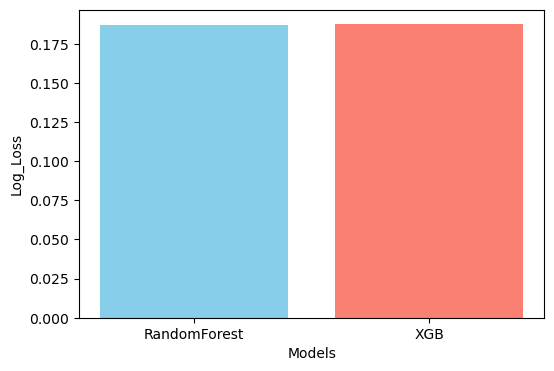

In [57]:
# making a list of models and log_loss
models = ['RandomForest', 'XGB']
log_loss = [rf_l_loss, xgb_l_loss]

# visualizing
plt.figure(figsize=(6, 4))
plt.bar(models, log_loss, color=['skyblue', 'salmon'])
plt.xlabel('Models')
plt.ylabel('Log_Loss')
plt.show()

**Since both are performing well and there is very little difference in log_loss value, will take `XGB model` forward considering its ability to generalise well on unseen data.**

# Evaluation

### Evaluating on val data

In [58]:
# predict on val data
val_preds = best_xgb_model.predict(x_val)
val_proba = best_xgb_model.predict_proba(x_val)[:, 1]
val_preds

array([0, 0, 1, ..., 1, 1, 0], shape=(101042,))

In [59]:
# scoring XGB on val data with recall, precision, f1, and class
print(classification_report(y_val, val_preds))

              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92     44986
         1.0       0.90      1.00      0.95     56056

    accuracy                           0.94    101042
   macro avg       0.95      0.93      0.93    101042
weighted avg       0.94      0.94      0.93    101042



In [60]:
# confusion matrix
confusion_matrix(y_val, val_preds)

array([[38611,  6375],
       [  133, 55923]])

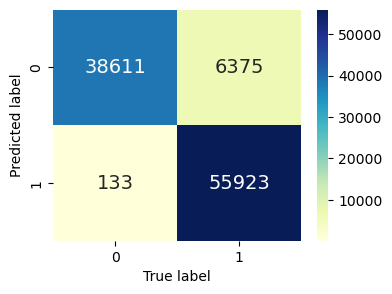

In [61]:
# plot Confusion matrix
def plot_conf_mat(y_true, y_preds):
    fig, ax = plt.subplots(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_true, y_preds),
                annot=True,
                fmt='d',
                cmap="YlGnBu",
                annot_kws={"size": 14})
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

# Using function
plot_conf_mat(y_val, val_preds)

In [62]:
from sklearn.metrics import log_loss

# Evaluating on recall_score, precision_score, f1_score, and log_loss
recall = recall_score(y_val, val_preds)
precision = precision_score(y_val, val_preds)
f1 = f1_score(y_val, val_preds)
val_log_loss = log_loss(y_val, val_proba)

# printing the scores
print(f'recall_score:{recall:.4f}')
print(f'precision_score:{precision:.4f}')
print(f'f1_score:{f1:.4f}')
print(f'log_loss_score:{val_log_loss:.4f}')

recall_score:0.9976
precision_score:0.8977
f1_score:0.9450
log_loss_score:0.1874


### Predicting on test data 

In [63]:
# Getting probabilities for churn (class = 1)
test_proba = best_xgb_model.predict_proba(x_test)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({
    "Id": test_ids,
    "Churn": test_proba
})

# Save to CSV
submission.to_csv("Churn_submission.csv", index=False)
print("Churn_submission.csv file created successfully!")

Churn_submission.csv file created successfully!


In [64]:
pd.read_csv('Churn_submission.csv')[:5]

,Id,Churn
0,105946,0.851723
1,101553,0.823119
2,468232,0.849184
3,249,0.995819
4,452750,0.006640


After submitting, the log_loss score on public leaderboard is `0.1883`

# Stratified K-fold

One more try to improve our `log_loss score`

In [65]:
# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# renaming 'Churn' to 'target' 
train_df.rename(columns={'Churn':'target'}, inplace=True)

# copying IDs from test data for the submission purpose
test_ids = test_df['Id'].copy()

# dropping 'ID' column form train and test data
train_df = train_df.drop('Id', axis=1)
test_df = test_df.drop('Id', axis=1)

# feature engineering
train_df["SubType_Contract"] = train_df["Subscription Type"] + "_" + train_df["Contract Length"]
test_df["SubType_Contract"] = test_df["Subscription Type"] + "_" + test_df["Contract Length"]

In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from xgboost import XGBClassifier

# Categorical alignment (train & test)
for col in ["Gender", "Subscription Type", "Contract Length", "SubType_Contract"]:
    categories = list(set(train_df[col].unique()) | set(test_df[col].unique()))
    train_df[col] = train_df[col].astype(pd.CategoricalDtype(categories=categories))
    test_df[col] = test_df[col].astype(pd.CategoricalDtype(categories=categories))

X = train_df.drop(columns=["target"])
y = train_df["target"]
X_test = test_df.copy()

# Stratified K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"=== Fold {fold} ===")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Best XGBClassifier model 
    params = {
        'n_estimators': 550, 
        'learning_rate': 0.01,
        'max_depth': 10,
        'min_child_weight': 5,
        'gamma': 0.5,
        'subsample': 0.8,
        'colsample_bytree': 1.0,
        'reg_alpha': 0,
        'reg_lambda': 1.5,
        'eval_metric': "logloss",
        'use_label_encoder': False,
        'enable_categorical':True,
        'random_state': 42
        }
    
    Ideal_model = XGBClassifier(**params)
    Ideal_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # OOF predictions
    val_pred = Ideal_model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred
    
    # Fold log loss
    fold_loss = log_loss(y_val, val_pred)
    fold_scores.append(fold_loss)
    print(f"Fold {fold} Loss: {fold_loss:.4f}")
    
    # Test predictions (accumulate, then average)
    test_preds += Ideal_model.predict_proba(X_test)[:, 1] / skf.n_splits

# Overall OOF performance
oof_loss = log_loss(y, oof_preds)
print(f"\nOverall OOF Log Loss: {oof_loss:.4f}")

# Final test predictions saved
submission = pd.DataFrame({
    "Id": test_ids,   # replace with your test ID column if exists
    "Churn": test_preds
})
submission.to_csv("submission_16.csv", index=False)
print("\n✅ Submission file saved as submission_16.csv")


=== Fold 1 ===


c:\Machine_Learning\kaggle-community-olympiad-customer-deflection\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:23:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1 Loss: 0.1824
=== Fold 2 ===


c:\Machine_Learning\kaggle-community-olympiad-customer-deflection\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:23:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 Loss: 0.1873
=== Fold 3 ===


c:\Machine_Learning\kaggle-community-olympiad-customer-deflection\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:24:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3 Loss: 0.1861
=== Fold 4 ===


c:\Machine_Learning\kaggle-community-olympiad-customer-deflection\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:24:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4 Loss: 0.1871
=== Fold 5 ===


c:\Machine_Learning\kaggle-community-olympiad-customer-deflection\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:24:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5 Loss: 0.1861

Overall OOF Log Loss: 0.1858

✅ Submission file saved as submission_16.csv


After submitting, the log_loss score on public leaderboard is `0.1866`

# Save Model

In [67]:
# Saving model
joblib.dump(Ideal_model, "churn_model.pkl")

['churn_model.pkl']

In [68]:
# Loading the model
loaded_model = joblib.load("churn_model.pkl")

In [70]:
# Predictions before saving
pred_before = Ideal_model.predict(x_val)

# Predictions after loading
pred_after = loaded_model.predict(x_val)

# Checking if model gives the same result after loading
print("Same predictions:", (pred_before == pred_after).all())

Same predictions: True
